In [178]:
try:
    # Cell 1: Import necessary libraries
    import os
    import glob
    import joblib
    import pandas as pd
    import numpy as np

    import matplotlib.pyplot as plt
    import seaborn as sns

    from sklearn.cluster import KMeans
    from kneed import KneeLocator

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import (
        classification_report,
        confusion_matrix,
        accuracy_score,
        silhouette_score,
    )
    from imblearn.over_sampling import SMOTE

except Exception as e:
    print(f"Error : {e}")

In [179]:
# Cell 2: Load the dataset
# Find the CSV file in the Datasets directory
data_path = '../Datasets/*.csv'
file_list = glob.glob(data_path)

if len(file_list) == 1:
    # Load the dataset
    df = pd.read_csv(file_list[0])
    print(f"Loaded dataset: {file_list[0]}")
else:
    raise FileNotFoundError(
        "No CSV file found or multiple CSV files found in the Datasets directory."
    )

Loaded dataset: ../Datasets/Dataset.csv


In [180]:
# Cell 3: Set the model saving path
destination = '../Models/'
os.makedirs(destination, exist_ok=True)
print(f"Model will be saved to: {destination}")

Model will be saved to: ../Models/


In [181]:
# Cell 4: Assign 'Unacceptable' to parts below threshold
clf_df = df.copy()
threshold_value = 1500

# Create 'Lifetime' column and assign 'Unacceptable' where 'Lifespan' < threshold_value
clf_df['Lifetime'] = np.where(
    clf_df['Lifespan'] < threshold_value, 'Unacceptable', None
)

# Display the first few rows
clf_df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType,Lifetime
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die,Unacceptable
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment,None
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment,Unacceptable
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous,Unacceptable
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die,None


In [182]:
# Cell 5: Perform K-Means clustering on acceptable parts
# Data to be clustered (Lifespan >= threshold_value)
acceptable_df = clf_df[clf_df['Lifespan'] >= threshold_value].copy()

# Selecting 'Lifespan' for clustering
X_acceptable = acceptable_df[['Lifespan']]

# Ensure there is enough data to cluster
if len(acceptable_df) > 1:
    # Initialize a list to store inertia values
    max_k = min(10, len(acceptable_df))
    k_values = range(1, max_k)

    inertia = []

    # Calculate inertia for each k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_acceptable)
        inertia.append(kmeans.inertia_)

    # Determine the optimal number of clusters using KneeLocator
    kneedle = KneeLocator(
        k_values, inertia, curve='convex', direction='decreasing'
    )
    elbow_k = kneedle.elbow

    # If elbow_k is None, default to 3
    if elbow_k is None:
        elbow_k = 3

    # Ensure elbow_k is not greater than max_k
    elbow_k = min(elbow_k, max_k - 1)

    # Perform KMeans clustering with elbow_k clusters
    kmeans = KMeans(n_clusters=elbow_k, random_state=42)
    acceptable_df['cluster'] = kmeans.fit_predict(X_acceptable)

    # Compute mean 'Lifespan' per cluster
    cluster_means = acceptable_df.groupby('cluster')['Lifespan'].mean()

    # Sort clusters by mean lifespan
    cluster_order = cluster_means.sort_values().index.tolist()

    # Define desired labels
    desired_labels = ['Fair', 'Good', 'Excellent']

    labels = []
    for i in range(elbow_k):
        if i < len(desired_labels):
            labels.append(desired_labels[i])
        else:
            # For additional clusters, create labels based on lifespan ranges
            cluster_idx = cluster_order[i]
            min_life = acceptable_df[acceptable_df['cluster'] == cluster_idx]['Lifespan'].min()
            max_life = acceptable_df[acceptable_df['cluster'] == cluster_idx]['Lifespan'].max()
            labels.append(f'{min_life:.2f}-{max_life:.2f}')

    # Create mapping from cluster index to label
    cluster_to_label = dict(zip(cluster_order, labels))

    # Map labels to 'Lifetime' column
    acceptable_df['Lifetime'] = acceptable_df['cluster'].map(cluster_to_label)

    # Update 'Lifetime' column in clf_df
    clf_df.loc[acceptable_df.index, 'Lifetime'] = acceptable_df['Lifetime']

    # Drop 'cluster' column if not needed
    acceptable_df.drop(columns=['cluster'], inplace=True)
else:
    print("Not enough data to perform clustering on acceptable parts.")

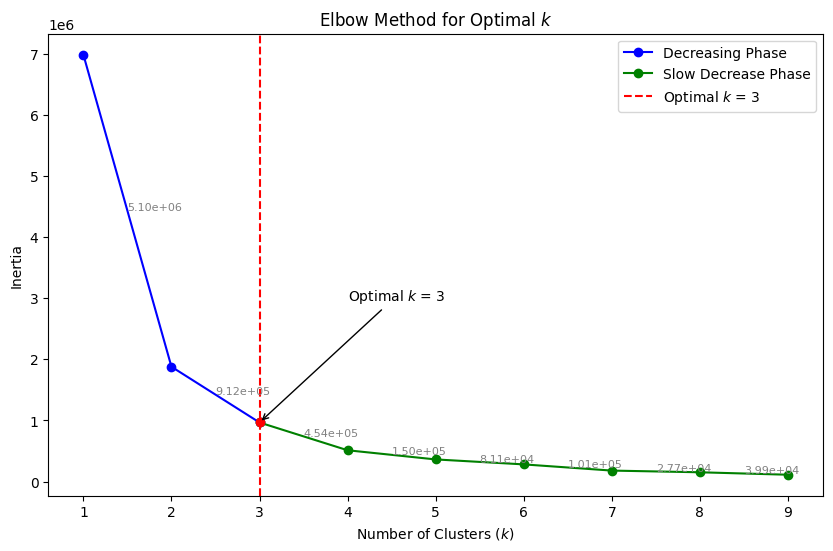

In [183]:
# Cell 6: Plot the Elbow Method
plt.figure(figsize=(10, 6))
# Plot line segments with different colors
plt.plot(k_values[:elbow_k], inertia[:elbow_k], 'bo-', label="Decreasing Phase")
plt.plot(k_values[elbow_k - 1:], inertia[elbow_k - 1:], 'go-', label="Slow Decrease Phase")

# Vertical line at elbow
plt.axvline(x=elbow_k, linestyle='--', color='r', label=f'Optimal $k$ = {elbow_k}')

# Highlight the elbow point with a red marker and annotation
plt.plot(elbow_k, inertia[elbow_k - 1], 'ro')  # red point at elbow
plt.annotate(f"Optimal $k$ = {elbow_k}", xy=(elbow_k, inertia[elbow_k - 1]),
             xytext=(elbow_k + 1, inertia[elbow_k - 1] + 0.2e7),
             arrowprops=dict(facecolor='black', arrowstyle="->"))

# Annotate each segment with inertia differences
for i in range(1, len(k_values)):
    plt.annotate(f"{inertia[i-1] - inertia[i]:.2e}",
                 (k_values[i] - 0.5, (inertia[i-1] + inertia[i]) / 2),
                 fontsize=8, color='gray')

# Set plot labels and title
plt.xlabel(f'Number of Clusters ($k$)')
plt.ylabel('Inertia')
plt.title(f'Elbow Method for Optimal $k$')
plt.legend()
plt.show()

In [184]:
# Cell 7: Display the cluster ranges
# Group the data by 'Lifetime' and aggregate to find the min and max Lifespan for each group
cluster_ranges = clf_df.groupby('Lifetime')['Lifespan'].agg(['min', 'max']).sort_values(by='min').reset_index()

# Display the sorted DataFrame
display(cluster_ranges)

,Lifetime,min,max
0,Unacceptable,417.99,1499.31
1,Fair,1501.76,1661.54
2,Good,1666.64,1850.75
3,Excellent,1854.50,2134.53


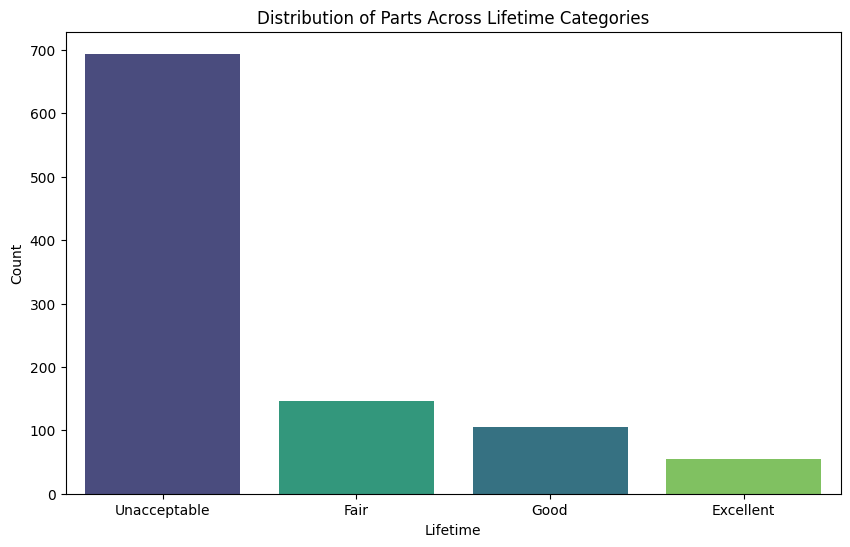

In [185]:
# Cell 9: Visualize the distribution of parts across Lifetime categories
plt.figure(figsize=(10, 6))
sns.countplot(
    x='Lifetime',
    data=clf_df,
    hue='Lifetime',
    order=cluster_ranges['Lifetime'].unique(),
    palette='viridis',
    dodge=False,
    legend=False
)
plt.xlabel('Lifetime')
plt.ylabel('Count')
plt.title('Distribution of Parts Across Lifetime Categories')
plt.show()

In [186]:
# Cell 9: Calculate the silhouette score
if len(acceptable_df['Lifetime'].unique()) > 1:
    # Map Lifetime labels back to cluster numbers for silhouette score
    label_to_cluster = {v: k for k, v in cluster_to_label.items()}
    acceptable_clusters = acceptable_df['Lifetime'].map(label_to_cluster)
    silhouette_avg = silhouette_score(X_acceptable, acceptable_clusters)
    print(f'Silhouette Score for k={elbow_k}: {silhouette_avg:.2f}')
else:
    print("Cannot compute silhouette score with only one cluster.")

Silhouette Score for k=3: 0.58


In [187]:
# Cell 10: Prepare data for Logistic Regression
# Ensure no missing values in 'Lifetime'
clf_df.dropna(subset=['Lifetime'], inplace=True)

# Splitting the features and target variable
X = clf_df.drop(columns=['Lifespan', 'Lifetime'])  # Exclude target and lifespan
y = clf_df['Lifetime']

In [188]:
# Cell 11: Encode categorical features and target label
# Encoding categorical features
categorical_features = X.select_dtypes(include=['object']).columns
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le  # Store the encoder for future use

# Encoding target labels
le_target = LabelEncoder()
y = le_target.fit_transform(y)

In [189]:
# Cell 12: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [190]:
# Cell 13: Address class imbalance using SMOTE
# Check class distribution before SMOTE
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(le_target.inverse_transform(unique), counts))
print("Class distribution before SMOTE:")
print(class_counts)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after SMOTE
unique_resampled, counts_resampled = np.unique(y_train_resampled, return_counts=True)
class_counts_resampled = dict(zip(le_target.inverse_transform(unique_resampled), counts_resampled))
print("\nClass distribution after applying SMOTE:")
print(class_counts_resampled)

Class distribution before SMOTE:
{'Excellent': np.int64(44), 'Fair': np.int64(117), 'Good': np.int64(84), 'Unacceptable': np.int64(555)}

Class distribution after applying SMOTE:
{'Excellent': np.int64(555), 'Fair': np.int64(555), 'Good': np.int64(555), 'Unacceptable': np.int64(555)}


In [191]:
# Cell 14: Standardize the features after resampling
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Convert scaled data back to DataFrame to retain feature names
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

In [192]:
# Cell 15: Create and train Logistic Regression model
# Option 1: With SMOTE-applied data
logistic_model_smote = LogisticRegression(max_iter=1000, random_state=42)

# # Option 2: Without SMOTE but with class weights
logistic_model_weighted = LogisticRegression(
    max_iter=1000, class_weight='balanced', random_state=42
)

In [193]:
logistic_model_smote.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [194]:
logistic_model_weighted.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [195]:
# Cell 16: Evaluate the model with SMOTE
# Predict on the test set
y_pred_smote = logistic_model_smote.predict(X_test)

# Model evaluation
accuracy_smote = accuracy_score(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
class_report_smote = classification_report(
    y_test, y_pred_smote, target_names=le_target.classes_
)

print("Model Evaluation with SMOTE:")
print(f"Accuracy: {accuracy_smote:.2f}")
print("Confusion Matrix:")
print(conf_matrix_smote)
print("Classification Report:")
print(class_report_smote)

# Evaluate the model with class weights
y_pred_weighted = logistic_model_weighted.predict(X_test)

accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
class_report_weighted = classification_report(
    y_test, y_pred_weighted, target_names=le_target.classes_
)

print("\nModel Evaluation with Class Weights:")
print(f"Accuracy: {accuracy_weighted:.2f}")
print("Confusion Matrix:")
print(conf_matrix_weighted)
print("Classification Report:")
print(class_report_weighted)

Model Evaluation with SMOTE:
Accuracy: 0.44
Confusion Matrix:
[[ 5  1  2  3]
 [ 6  4  7 12]
 [ 6  6  4  5]
 [15 28 21 75]]
Classification Report:
              precision    recall  f1-score   support

   Excellent       0.16      0.45      0.23        11
        Fair       0.10      0.14      0.12        29
        Good       0.12      0.19      0.15        21
Unacceptable       0.79      0.54      0.64       139

    accuracy                           0.44       200
   macro avg       0.29      0.33      0.28       200
weighted avg       0.58      0.44      0.49       200


Model Evaluation with Class Weights:
Accuracy: 0.38
Confusion Matrix:
[[ 4  2  1  4]
 [ 7  6  5 11]
 [ 5  6  3  7]
 [35 24 17 63]]
Classification Report:
              precision    recall  f1-score   support

   Excellent       0.08      0.36      0.13        11
        Fair       0.16      0.21      0.18        29
        Good       0.12      0.14      0.13        21
Unacceptable       0.74      0.45      0.56    

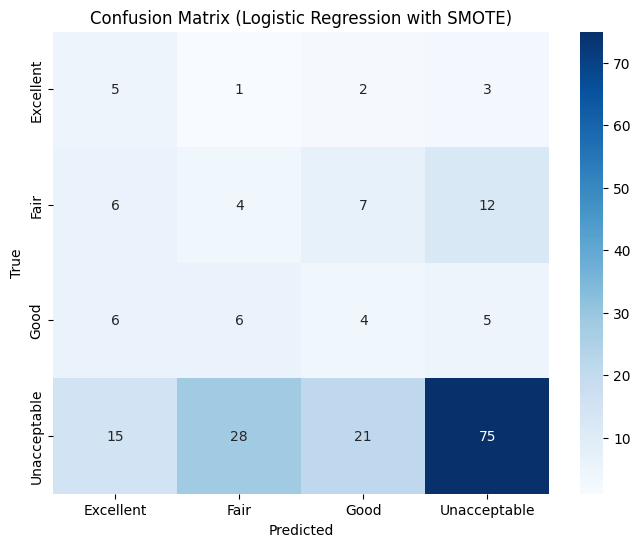

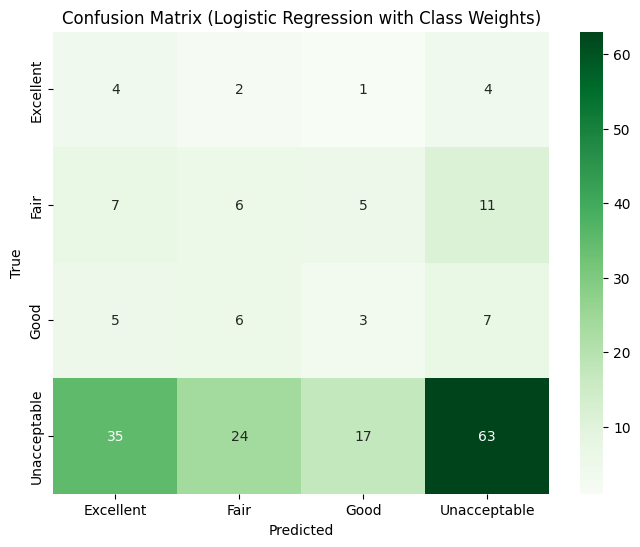

In [196]:
# Cell 17: Visualize the confusion matrix for the SMOTE model
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_smote,
    annot=True,
    cmap='Blues',
    fmt='g',
    xticklabels=le_target.classes_,
    yticklabels=le_target.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Logistic Regression with SMOTE)')
plt.show()

# Visualize the confusion matrix for the weighted model
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_weighted,
    annot=True,
    cmap='Greens',
    fmt='g',
    xticklabels=le_target.classes_,
    yticklabels=le_target.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Logistic Regression with Class Weights)')
plt.show()

In [197]:
# Cell 18: Save the trained model
# Save the model trained with SMOTE
model_filename_smote = os.path.join(destination, 'LogisticRegressionModel_SMOTE.pkl')
joblib.dump(logistic_model_smote, model_filename_smote)
print(f"Model saved to: {model_filename_smote}")

# Save the model trained with class weights
model_filename_weighted = os.path.join(destination, 'LogisticRegressionModel_Weighted.pkl')
joblib.dump(logistic_model_weighted, model_filename_weighted)
print(f"Model saved to: {model_filename_weighted}")

Model saved to: ../Models/LogisticRegressionModel_SMOTE.pkl
Model saved to: ../Models/LogisticRegressionModel_Weighted.pkl


In [198]:
# Cell 19: Make predictions and analyze misclassifications
# If you have used LabelEncoder for the target labels, decode them back to original labels
y_test_labels = le_target.inverse_transform(y_test)
y_pred_labels = le_target.inverse_transform(y_pred_smote)

# Create a DataFrame with actual and predicted labels
predictions_df = pd.DataFrame({
    'Actual': y_test_labels,
    'Predicted': y_pred_labels
})

# Optionally, include the predicted probabilities
y_pred_proba = logistic_model_smote.predict_proba(X_test)

# Add probabilities for each class
for i, class_label in enumerate(le_target.classes_):
    predictions_df[f'Prob_{class_label}'] = y_pred_proba[:, i]

# Display the DataFrame
display(predictions_df.head())

# Save predictions to a CSV file if desired
predictions_df.to_csv('../Models/test_predictions.csv', index=False)

# Filter misclassified samples
misclassified = predictions_df[predictions_df['Actual'] != predictions_df['Predicted']]
print("Misclassified Samples:")
display(misclassified)

,Actual,Predicted,Prob_Excellent,Prob_Fair,Prob_Good,Prob_Unacceptable
0,Unacceptable,Excellent,0.330439,0.236353,0.306292,0.126916
1,Unacceptable,Fair,0.108493,0.499711,0.342613,0.049183
2,Excellent,Fair,0.018302,0.474192,0.187140,0.320366
3,Unacceptable,Excellent,0.732963,0.165453,0.061366,0.040219
4,Unacceptable,Unacceptable,0.094895,0.226318,0.211750,0.467037


Misclassified Samples:


,Actual,Predicted,Prob_Excellent,Prob_Fair,Prob_Good,Prob_Unacceptable
0,Unacceptable,Excellent,0.330439,0.236353,0.306292,0.126916
1,Unacceptable,Fair,0.108493,0.499711,0.342613,0.049183
2,Excellent,Fair,0.018302,0.474192,0.187140,0.320366
3,Unacceptable,Excellent,0.732963,0.165453,0.061366,0.040219
5,Excellent,Unacceptable,0.033688,0.020830,0.106216,0.839266
...,...,...,...,...,...,...
190,Unacceptable,Fair,0.050884,0.560398,0.089260,0.299459
192,Unacceptable,Good,0.186184,0.218329,0.339178,0.256308
194,Unacceptable,Fair,0.088903,0.428268,0.266827,0.216003
198,Good,Fair,0.126978,0.413325,0.232610,0.227086


In [199]:
# Cell 20: Combine feature values with predictions
# If X_test is standardized, you might want to inverse transform it (if you need original values)
# However, since we are mainly interested in the features, we can proceed

# Convert X_test to a DataFrame if it's not already
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Combine feature values with predictions
predictions_full_df = pd.concat(
    [X_test_df.reset_index(drop=True), predictions_df.reset_index(drop=True)], axis=1
)

# Display the DataFrame
display(predictions_full_df.head())

,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,...,largeDefects,sliverDefects,seedLocation,castType,Actual,Predicted,Prob_Excellent,Prob_Fair,Prob_Good,Prob_Unacceptable
0,0.737825,1.557596,2.091128,-0.594891,-0.221449,0.575222,0.358888,0.597380,-1.629246,0.866377,...,-0.471334,-0.229481,-0.684291,-1.029341,Unacceptable,Excellent,0.330439,0.236353,0.306292,0.126916
1,-1.301990,-1.195480,-1.728044,0.556585,0.661772,-0.869002,-1.561023,1.437083,-0.547145,0.376365,...,-0.471334,-0.229481,-0.684291,-1.029341,Unacceptable,Fair,0.108493,0.499711,0.342613,0.049183
2,-0.282083,-1.195480,-0.320981,-0.656894,-1.109021,-0.134795,-0.974607,1.422141,-0.744328,-1.373678,...,-0.471334,-0.229481,1.461367,-1.029341,Excellent,Fair,0.018302,0.474192,0.187140,0.320366
3,-0.282083,-1.195480,1.689110,1.034890,-1.752946,1.137482,1.660251,0.164082,-1.723029,-1.924942,...,-0.471334,-0.229481,-0.684291,1.708991,Unacceptable,Excellent,0.732963,0.165453,0.061366,0.040219
4,-1.301990,1.557596,-1.929053,-1.657792,1.183873,0.858313,0.027523,0.727370,-1.670126,1.697648,...,-0.471334,3.100245,1.461367,-1.029341,Unacceptable,Unacceptable,0.094895,0.226318,0.211750,0.467037
